# 1. EDA

### 데이터 둘러보기

* 필요한 모듈 불러오기

In [190]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

* train, test 파일 불러오기

In [191]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

In [192]:
train.shape, test.shape

((891, 12), (418, 11))

* 파일 둘러보기
 * Survived : 탑승객 생존 유무 (0이면 사망, 1이면 생존)
 * Sibsp : 함께 탑승한 형제자매, 아내, 남편의 수
 * Parch : 함께 탑승한 부모, 자식의 수
 * Cabin : 객실번호
 * Embarked : 배에 탑승한 항구 이름 ( C = Cherbourn, Q = Queenstown, S = Southampton)

In [193]:
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [194]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


=> Age, Fare, Cabin, Embarked 열에 결측치 있음 (특히 Age 열에 대한 결측치 처리가 key가 될 것으로 보임)<br>
=> Cabin 열에 대한 결측치 90% 가까이 되기 때문에 해당 열 제거<br>
=> Sex, Embarked와 같은 범주형 변수에 대한 인코딩 필요

### 데이터 시각화

* Survived에 대한 비율

<AxesSubplot:>

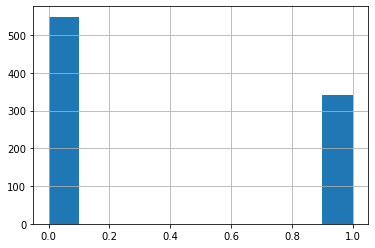

In [195]:
train['Survived'].hist()

=> 타깃값인 Survived의 라벨 불균형이 있으므로 데이터 전처리 과정에서 오버샘플링을 통해 해당 비율을 맞춰주어야 함

* Pclass에 따른 생존율

In [196]:
pclass_group = train.groupby('Pclass').mean()['Survived']
pclass_group

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

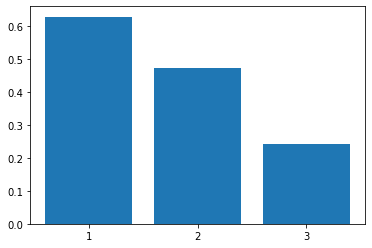

In [197]:
plt.bar(['1', '2', '3'], pclass_group.values)
plt.show()

=> 예상한대로 등급이 높을수록 생존율이 높음<br>
=> 등실의 등급에 따라 생존율의 유의미한 차이가 나타나는 것을 알 수 있음

* Sex에 따른 생존율

In [198]:
sex_group = train.groupby('Sex').mean()['Survived']
sex_group

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

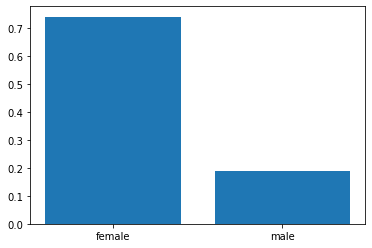

In [199]:
plt.bar(sex_group.index, sex_group.values)
plt.show()

=> 여자의 생존율이 몇 배나 더 높음<br>
=> Sex에 따른 생존의 유의미한 차이가 나타남

* 나이에 따른 생존율
 * 나이대를 나타내는 범주형 변수를 생성하여 나이대별 생존율의 유의미한 차이가 있는지 파악

In [200]:
train['Age'].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

=> 최소값이 약 0, 최대값이 80인 것으로 보아 데이터 범위가 굉장히 넓고, 편차가 큼<br>

In [201]:
def age_func(age): # 나이대를 생성하는 함수
    age = (age // 10) * 10
    return age 

In [202]:
age_cate = train['Age'].apply(lambda x: age_func(x))
age_cate = pd.DataFrame(age_cate) # 기존 train df에 추가하기보다는 새 df를 생성
age_cate['Survived'] = train['Survived']
age_group = age_cate.groupby('Age').mean()['Survived']
age_group

Age
0.0     0.612903
10.0    0.401961
20.0    0.350000
30.0    0.437126
40.0    0.382022
50.0    0.416667
60.0    0.315789
70.0    0.000000
80.0    1.000000
Name: Survived, dtype: float64

=> 영유아의 생존률의 50%를 넘어가며, 다른 연령대에 비해 생존률이 높음

<AxesSubplot:>

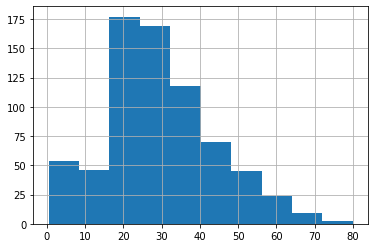

In [203]:
train['Age'].hist()

=> 추후 분포 변환을 고려

* Sibsp, Parch 분포도 파악

<AxesSubplot:>

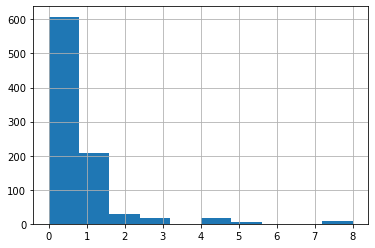

In [205]:
train['SibSp'].hist()

<AxesSubplot:>

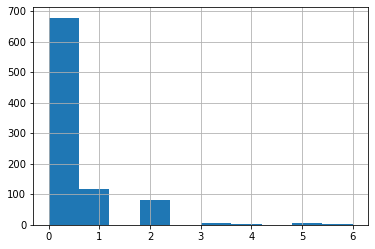

In [206]:
train['Parch'].hist()

=> SibSp, Parch 모두 혼자 탑승하거나 1인 동반으로 탑승한 경우가 많음<br>
=> 두 변수를 합친 파생변수 고려

* Fare 분포도 파악

<AxesSubplot:>

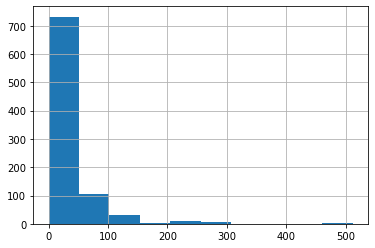

In [207]:
train['Fare'].hist()

=> 싼 요금을 내고 탑승한 사람들이 거의 대부분이며 200 ~ 300, 500은 1 ~ 2등급에 탑승한 사람들일 것임<br>

In [208]:
train[train['Fare'] == 0]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
179,180,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,NaN,S
263,264,0,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.0,B94,S
271,272,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0,NaN,S
277,278,0,2,"Parkes, Mr. Francis ""Frank""",male,NaN,0,0,239853,0.0,NaN,S
302,303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,NaN,S
413,414,0,2,"Cunningham, Mr. Alfred Fleming",male,NaN,0,0,239853,0.0,NaN,S
466,467,0,2,"Campbell, Mr. William",male,NaN,0,0,239853,0.0,NaN,S
481,482,0,2,"Frost, Mr. Anthony Wood ""Archie""",male,NaN,0,0,239854,0.0,NaN,S
597,598,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0,NaN,S
633,634,0,1,"Parr, Mr. William Henry Marsh",male,NaN,0,0,112052,0.0,NaN,S


=> 요금이 0인 데이터 .. ?

* Pclass 분포도 확인

<AxesSubplot:>

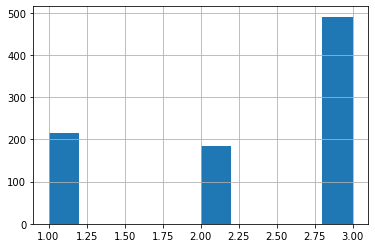

In [209]:
train['Pclass'].hist()

=> 등실의 등급에 따른 분포를 확인해보면 요금과 비슷한 양상의 분포를 확인할 수 있음

# 2. 전처리

* 데이터 합치기

In [210]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


=> 활용할 수 없는 열을 일단 제거하기<br>
=> Age, Fare, Embarked에 결측치 처리 방법 고민하기<br>
=> 범주형 자료 인코딩하기

In [211]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


=> 활용할 수 없는 열을 일단 제거하기<br>
=> Age, Fare에 결측치 처리 방법 고민하기<br>
=> 범주형 자료 인코딩하기

### 결측치 처리
 * 1. Fare
 * 2. Embarked
 * 3. Age

* 1. Fare 결측치 처리
 * train에는 결측치가 없고, test에만 결측치가 있음
 * test에서 Fare와 상관관계가 높은 열을 찾아보자 !

In [212]:
test.corr()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.026751,-0.034102,0.003818,0.043080,0.008211
Pclass,-0.026751,1.000000,-0.492143,0.001087,0.018721,-0.577147
Age,-0.034102,-0.492143,1.000000,-0.091587,-0.061249,0.337932
SibSp,0.003818,0.001087,-0.091587,1.000000,0.306895,0.171539
Parch,0.043080,0.018721,-0.061249,0.306895,1.000000,0.230046
Fare,0.008211,-0.577147,0.337932,0.171539,0.230046,1.000000


=> Pclass와 Fare의 상관관계가 높음<br>
=> Fare의 결측치를 처리할 때 Fare 열을 이용해보자 !

In [213]:
test[test['Fare'].isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


=> Pclass가 3임<br>
=> Pclass가 3인 데이터만 뽑아 Fare의 결측치를 채움

In [214]:
test[test['Pclass'] == 3]['Fare'].value_counts() # Pclass = 3인 데이터의 개수가 218개이므로 상위 10%의 데이터인 7.75로 결측치 대체

7.7500     21
8.0500     17
7.8958     11
7.7750     10
7.2292      9
           ..
16.7000     1
23.2500     1
25.4667     1
18.0000     1
22.3583     1
Name: Fare, Length: 79, dtype: int64

In [215]:
test['Fare'] = test['Fare'].fillna(7.75)

* Embarked 결측치 처리

In [216]:
train[train['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [217]:
train['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

=> Embarked의 가장 높은 빈도인 S로 결측치를 대체

In [218]:
train['Embarked'] = train['Embarked'].fillna('S')

* 3. Age 결측치 처리
 * 나이의 결측값 처리가 상당히 중요하다고 판단
 * 나이의 편차가 커 단순 평균으로 결측값을 대체하는 것은 너무 리스크가 큼
 * 나이의 결측값을 처리할 수 있는 효과적인 방법이 없을까 ?
 * 다양한 방법을 시도하면서 정확도를 올려보자 !
 * 이름의 이니셜을 이용한 방법이 가장 정확도가 높았음<br>
 https://www.kaggle.com/code/ash316/eda-to-prediction-dietanic/notebook<br>
 => 방법을 고민하다가 위 링크의 EDA를 참고해서 처리했음

In [219]:
train['Initial'] = 0
for i in train:
    train['Initial'] = train['Name'].str.extract('([A-Za-z]+)\.') # .을 기준으로 앞에 있는 부분을 추출하는 정규표현식
    
test['Initial']=0
for i in test:
    test['Initial'] = test.Name.str.extract('([A-Za-z]+)\.')

In [220]:
train['Initial'].head(10)

0        Mr
1       Mrs
2      Miss
3       Mrs
4        Mr
5        Mr
6        Mr
7    Master
8       Mrs
9       Mrs
Name: Initial, dtype: object

=> 이렇게 이니셜이 잘 분리된 열을 생성할 수 있음

In [221]:
train['Initial'].value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Major         2
Col           2
Countess      1
Capt          1
Ms            1
Sir           1
Lady          1
Mme           1
Don           1
Jonkheer      1
Name: Initial, dtype: int64

In [222]:
test['Initial'].value_counts()

Mr        240
Miss       78
Mrs        72
Master     21
Col         2
Rev         2
Ms          1
Dr          1
Dona        1
Name: Initial, dtype: int64

=> 10개 이하의 빈도를 가지는 이니셜들을 하나씩 처리해주면 예측 정확도가 떨어질 것 같음

In [223]:
# 다양한 이니셜들을 Mr, Miss, Mrs, Master, Other로 변환해줌
train['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don'],['Miss','Miss','Miss','Mr','Mrs','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr'], inplace = True)
test['Initial'].replace(['Rev','Col','Dr','Dona','Ms'],['Other','Other','Mr','Mr',"Miss"],inplace=True)

In [224]:
# 이니셜에 따른 나이의 평균
train.groupby('Initial')['Age'].mean()

Initial
Master     4.574167
Miss      21.860000
Mr        32.662162
Mrs       36.205357
Other     45.888889
Name: Age, dtype: float64

In [225]:
# 이니셜에 따라 나이의 결측값을 채우기
train.loc[(train.Age.isnull()) & (train.Initial=='Mr'),'Age'] = 33
train.loc[(train.Age.isnull()) & (train.Initial=='Mrs'),'Age'] = 36
train.loc[(train.Age.isnull()) & (train.Initial=='Master'),'Age'] = 5
train.loc[(train.Age.isnull()) & (train.Initial=='Miss'),'Age'] = 22
train.loc[(train.Age.isnull()) & (train.Initial=='Other'),'Age'] = 46

test.loc[(test.Age.isnull()) & (test.Initial=='Mr'),'Age'] = 33
test.loc[(test.Age.isnull()) & (test.Initial=='Mrs'),'Age'] = 36
test.loc[(test.Age.isnull()) & (test.Initial=='Master'),'Age'] = 5
test.loc[(test.Age.isnull()) & (test.Initial=='Miss'),'Age'] = 22
test.loc[(test.Age.isnull()) & (test.Initial=='Other'),'Age'] = 46

### 파생변수 생성

In [226]:
# family size 변수 생성
train['family_size'] = train['SibSp'] + train['Parch'] + 1
test['family_size'] = test['SibSp'] + test['Parch'] + 1

# solo 변수 생성
train['solo'] = (train['family_size'] == 1)
test['solo'] = (test['family_size'] == 1) 

### 필요없는 열 제거

In [227]:
train.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis = 1, inplace = True)
test.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis = 1, inplace = True)

### 인코딩

In [228]:
train = pd.get_dummies(train, columns = ['Sex', 'Embarked', 'Initial'])
test = pd.get_dummies(test, columns = ['Sex', 'Embarked', 'Initial'])

### 데이터 분리

In [229]:
train_x = train.drop(['Survived'], axis = 1)
train_y = train['Survived']
test_x = test

# 3. 모델링

### 랜덤 포레스트

In [230]:
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

In [231]:
# GridSearchCV
from sklearn.model_selection import GridSearchCV, KFold

param_grid = params ={
    'n_estimators':[50,100],
    'max_depth':[6,8,10,12],
    'min_samples_leaf':[8,12,18],
    'min_samples_split':[8,16,20]
}

rf = RandomForestClassifier()
cv = KFold(n_splits=6)
grid_rf = GridSearchCV(rf, param_grid, cv=cv, scoring = 'accuracy')
grid_rf.fit(train_x, train_y)
print('final parmas', grid_rf.best_params_)
print('best score', grid_rf.best_score_)

final parmas {'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 100}
best score 0.837248322147651


In [232]:
# 학습
rf_best = grid_rf.best_estimator_

# 예측
pred = rf_best.predict(test_x)

# 결과 제출
submission = pd.read_csv("./submission.csv")
submission['Survived'] = pred
submission.to_csv('./RandomForestClassifier_민영.csv', index = False)

### 오버 샘플링
* 레이블이 불균형한 분포를 가진 데이터 세트를 학습시킬 때 예측 성능의 문제 발생 => 다양한 유형을 학습하지 못하기 때문
* 적절한 학습 데이터를 확보하는 방안이 필요 => 언더 샘플링, 오버 샘플링 => 오버 샘플링 방식이 예측 성능상 조금 유리한 경우가 많음
* SMOTE방식 : 적은 데이터 세트(1인 생존 데이터가 더 적음)에 있는 개별 데이터들의 K 최근접 이웃을 찾아서 이 데이터와 K개 이웃들의 차이를 일정값으로 만들어서 기존 데이터와 약간 차이가 나는 새로운 데이터들을 생성하는 방식

In [233]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
train_x_over, train_y_over = smote.fit_resample(train_x, train_y)

In [234]:
# GridSearchCV
from sklearn.model_selection import GridSearchCV, KFold

param_grid = params ={
    'n_estimators':[50,100],
    'max_depth':[6,8,10,12],
    'min_samples_leaf':[8,12,18],
    'min_samples_split':[8,16,20]
}

rf = RandomForestClassifier()
cv = KFold(n_splits=6)
grid_rf = GridSearchCV(rf, param_grid, cv=cv, scoring = 'accuracy')
grid_rf.fit(train_x_over, train_y_over)
print('final parmas', grid_rf.best_params_)
print('best score', grid_rf.best_score_)

final parmas {'max_depth': 8, 'min_samples_leaf': 8, 'min_samples_split': 20, 'n_estimators': 50}
best score 0.8324225865209472


In [235]:
# 학습
rf_best = grid_rf.best_estimator_

# 예측
pred = rf_best.predict(test_x)

# 결과 제출
submission = pd.read_csv("./submission.csv")
submission['Survived'] = pred
submission.to_csv('./RandomForestClassifier_smote_민영.csv', index = False)

=> 0.7651655307 (396등)